＃ Analysis with higher resolution

In this note book, we analyze the grid data with higher resolution than in the main text (resolition=2).

First, we obtain the climate conditions for real animal with high resolution.
we obtain the hex grid of the trickster animals with the higher resolution.
Then, we will see whether the real animal exist or not whne the corresponding tricksters are reported.
Finally, we will obtain the climate information for tricksters.


In [16]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import sys
import os
import random
import scipy as sp
from statsmodels.stats import multitest
import math
#import rioxarray as rxr  we used this function to read tiff, but could cause conflict with plotting hex grids
import h3
from latlon_utils import get_climate
#from geojson import Feature, Point, FeatureCollection, Polygon
os.getcwd()

'/Users/shibasakishota/Desktop/Trickster1'

In [9]:
# read all real animal distributiosn
df_meta=pd.read_csv('./GBIF/For_gbif_trickstar.xlsx - Sheet1.csv') # meta file
species=np.unique(df_meta['Category'])
for i in range(len(species)):
    target=species[i]
    print(target)
    if target != 'water bird' and target != 'monkey':
        taxa=df_meta[df_meta['Category']==target]['Taxa'].reset_index(drop=True)
        for j in range(len(taxa)):
            if i==0 and j==0:
                data=pd.read_csv('./GBIF/'+target+'/'+taxa[j]+'_cleaned.csv')
                data["Species"]=target
            else:
                dd=pd.read_csv('./GBIF/'+target+'/'+taxa[j]+'_cleaned.csv')
                dd["Species"]=target
                data=pd.concat([data,dd])
# extract climate data using the center of each grid
def Add_Temp_Prec(df_hex):
    Temp=[]
    Prec=[]
    center_lng=[]
    center_lat=[]
    hex_grid=np.unique(df_hex['hex_index2']) # we will get indeces of higher resolution scenario
    for i in range(len(hex_grid)):
        x=h3.h3_to_geo_boundary(hex_grid[i], True)
        x=np.mean(x, axis=0)
        center_lng.append(x[0])
        center_lat.append(x[1])
    df=pd.DataFrame({'Lat':center_lat, 'Lng':center_lng, 'hex_index':hex_grid})
    print('Start extracting clim data')
    for i in range(len(df)):
        #print(df['hex_index'][i])
        d=get_climate(df.iloc[i, 0], df.iloc[i, 1])
        if np.isnan(d.tavg.ann)==True or np.isnan(sum(d.prec[1:12]))==True:
            # estimate from the data
            d_extract=df_hex[df_hex['hex_index']==hex_grid[i]]
            d_extract=d_extract[d_extract['decimalLatitude']<89.5] # unable to get data lat is too close to 90
            d_extract=d_extract[d_extract['decimalLongitude']<179.9] # unable to get data lng is too close to 180
            d=get_climate(d_extract.iloc[:, 1], d_extract.iloc[:, 0]) # note the lat and lng are swapped
            Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature 
            Prec.append(np.nanmean(np.sum(d.prec.iloc[:,:12], axis=1))) # annual precipition
        else:
            Temp.append(d.tavg.ann)
            Prec.append(sum(d.prec[1:12]))
    df['Annu_Mean_Temp']=Temp
    df['Annu_Prec']=Prec
    return df
df_real=Add_Temp_Prec(data)
df_real.head()

anteater
badger
ground squirrel
hawk
mink
monkey
mouse
opossum
owl
porcupine
rabbit
raccoon
rat
raven
skunk
spider
water bird
wren
Start extracting clim data


/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_19930/724939985.py:38: RuntimeWarning: Mean of empty slice
  Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_19930/724939985.py:39: RuntimeWarning: Mean of empty slice
  Prec.append(np.nanmean(np.sum(d.prec.iloc[:,:12], axis=1))) # annual precipition
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_19930/724939985.py:38: RuntimeWarning: Mean of empty slice
  Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_19930/724939985.py:39: RuntimeWarning: Mean of empty slice
  Prec.append(np.nanmean(np.sum(d.prec.iloc[:,:12], axis=1))) # annual precipition
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_19930/724939985.py:38: RuntimeWarning: Mean of empty slice
  Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature
/var/folders/g4/3cvylr8j6mq822n672

,Lat,Lng,hex_index,Annu_Mean_Temp,Annu_Prec
0,78.972490,37.783954,820007fffffffff,NaN,NaN
1,77.877649,51.256126,820017fffffffff,NaN,NaN
2,80.752428,49.953373,82001ffffffffff,-13.802734,240.0
3,76.928745,29.531807,820027fffffffff,NaN,NaN
4,79.376753,22.650713,82002ffffffffff,-8.735743,390.0


In [101]:
df_real.dropna().to_csv("Real_animal_hex_biome2.csv", index=False)

# Conditional prob that the real animals exist in the grids where the corresponding trickster animals are reported

In [183]:
df=pd.read_csv('./TrickSter_data3.csv') # trickster data with lower resolution
df = df.query("TrickSter not in ['monkey', 'water bird']") # we do not need the data of monky and water bird
trickster=df["TrickSter"].unique()
df=df[["nid", "lat", "lng", "TrickSter"]] # to avoid confusion, drop unused data

hex_index=[]
for i in range(len(df)):
    # get hex grid with resolution two
    hex_index.append(h3.geo_to_h3(df.iloc[i, 1], df.iloc[i, 2], 2)) 
    # check whether the corresponding real animal exist in the grids or nore
df["hex_index"]=hex_index
df=ExtractHexIndex(df, 2) 
df.head()

# check the presence of real animals
df_meta=pd.read_csv('./GBIF/For_gbif_trickstar.xlsx - Sheet1.csv') # meta file
presence=[]
Temp=[]
Prec=[]
for i in range(len(trickster)):
#for i in range(1):
    target=trickster[i]
    print(target)
    if target != 'water bird' and target != 'monkey':
        taxa=df_meta[df_meta['Category']==target]['Taxa'].reset_index(drop=True)
        for j in range(len(taxa)):
            if j==0:
                data=pd.read_csv('./GBIF/'+target+'/'+taxa[j]+'_cleaned.csv')
                data["Species"]=target
            else:
                dd=pd.read_csv('./GBIF/'+target+'/'+taxa[j]+'_cleaned.csv')
                dd["Species"]=target
                data=pd.concat([data,dd])
    df_extract=df[df["TrickSter"]==target].reset_index()
    for k in range(len(df_extract)):
        presence.append(df_extract["hex_index"][k] in data["hex_index2"].to_list()) # whether real animal exists when the tricksters are reporeted
        # add climate data
        x=h3.h3_to_geo_boundary(df_extract["hex_index"][k], True)
        x=np.mean(x, axis=0)
        center_lng=x[0]
        center_lat=x[1]
        d=get_climate(center_lat, center_lng)
        Temp.append(d.tavg.ann)
        Prec.append(sum(d.prec[1:12]))
df["Presence"]=presence
df["Annu_mean_temp"]=Temp
df["Annu_mean_prec"]=Prec
        
        

raven
skunk
mink
rabbit
owl
hawk
opossum
rat
mouse
ground squirrel
spider
raccoon
anteater
porcupine
badger
wren


In [188]:
df.to_csv("TrickSter_data4.csv", index=False)

raven
skunk
mink
rabbit
owl
hawk
opossum
rat
mouse
ground squirrel
spider
raccoon
anteater
porcupine
badger
wren


<ErrorbarContainer object of 3 artists>

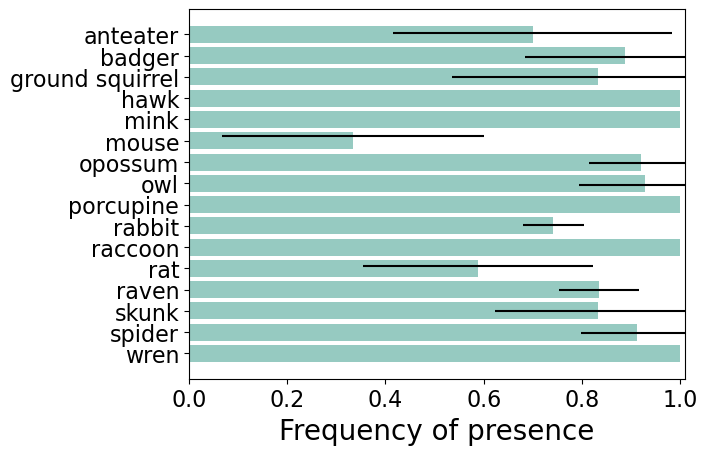

In [191]:
def Presence_Rate(df=df):
    # Prob(real animal presence | tricksters is presence)
    Count=[]
    Trickster=[]
    Presence=[]
    Frequency=[]
    Error=[]
    tricksters_array=df['TrickSter'].unique()
    for i in range(len(tricksters_array)):
        target=tricksters_array[i]
        print(target)
        n=len(df[df['TrickSter']==target]['Presence'])
        x=sum(df[df['TrickSter']==target]['Presence'])
        p=x/n
        Presence.append(x)
        Count.append(n)
        Trickster.append(target)
        Error.append(1.96*np.sqrt(p*(1-p)/n)) # .95 confidence interval
        Frequency.append(p)
    return pd.DataFrame({'Trickster':Trickster, 'Presence':Presence, 'Total':Count, 'Frequency':Frequency, '95CI':Error})
df1=Presence_Rate(df=df)
# remove some species that we do not analyze
df1=df1.sort_values('Trickster')
#------Plot the conditional probability-------------------
ax=sns.barplot(data=df1, y='Trickster', x='Frequency', color="#8dd3c7")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Frequency of presence', fontsize=20)
plt.ylabel('')
plt.xlim(0, 1.01)
y_coords = [p.get_y()+0.5* p.get_width() for p in ax.patches]
x_coords = df1['Frequency']
ax.errorbar(x=x_coords, y=y_coords, xerr=df1["95CI"], fmt="none", c="k")
#plt.show()
#plt.savefig('Presence_Trickster_Animal.pdf', bbox_inches='tight', pad_inches=0.05)

In [192]:
df1

,Trickster,Presence,Total,Frequency,95CI
12,anteater,7,10,0.700000,0.284031
14,badger,8,9,0.888889,0.205323
9,ground squirrel,5,6,0.833333,0.298205
5,hawk,13,13,1.000000,0.000000
2,mink,9,9,1.000000,0.000000
8,mouse,4,12,0.333333,0.266722
6,opossum,23,25,0.920000,0.106347
4,owl,13,14,0.928571,0.134907
13,porcupine,18,18,1.000000,0.000000
3,rabbit,141,190,0.742105,0.062206


# Permutation test

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import sys
import latlon_utils 
#import rioxarray as rxr  we used this function to read tiff, but could cause conflict with plotting hex grids
import h3
from geopy.distance import geodesic
#from geojson import Feature, Point, FeatureCollection, Polygon
import plotly.express as px
import random
import scipy as sp
from scipy.integrate import cumtrapz
import statsmodels
from statsmodels.stats import multitest
import math
#import statannot
df=pd.read_csv('TrickSter_data4.csv')

In [4]:
def MedianDistance(data):
    # calculate median distance given data points
    center_lng=[]
    center_lat=[]
    for i in range(len(data)):
        x=h3.h3_to_geo_boundary(data[i], True)
        x=np.mean(x, axis=0)
        center_lng.append(x[0])
        center_lat.append(x[1])
    df=pd.DataFrame({'latitude':center_lat, 'longitude':center_lng})
    Distance=[] # realized distances between tricksters
    for i in range(len(df)):
        place1=df.iloc[i, :]
        for j in range(i+1, len(df)):
            place2=df.iloc[j, :]
            Distance.append(geodesic(place1, place2).km)
    return np.median(Distance)

def Distribution_Test(df, target, rep=10000):
    # Test whether TS is more dense than random distributions on RA
    # df: data farme of tricksters. See above as an example
    # target: str of target species
    # rep: int of replications to generate a median distributions under the null hypothesis
    if target == 'water bird' or target == "monkey" or target == 'ground_squirrel':
        print ("We ignore this species")
        return np.nan
    else:
        #---------------------------------------------------------------------------------------------
        # Step　1: calculate distances between tricksters
        hex_TS=np.unique(df[df['TrickSter']==target]['hex_index']) # hex_grids of focal Tricksters
        median_TS=MedianDistance(hex_TS)
        #---------------------------------------------------------------------------------------------
        # Step　2: calculate distances under null hypothesis (random distirbutions of TS given RA exist)
        df_meta=pd.read_csv('./GBIF/For_gbif_trickstar.xlsx - Sheet1.csv') # meta file
        taxa=df_meta[df_meta['Category']==target]['Taxa'].reset_index(drop=True)
        for i in range(len(taxa)):
            if i==0:
                data=pd.read_csv('./GBIF/'+target+'/'+taxa[i]+'_cleaned.csv')
            else:
                dd=pd.read_csv('./GBIF/'+target+'/'+taxa[i]+'_cleaned.csv')
                data=pd.concat([data,dd])
        #print(data)
        hex_RA=np.unique(data['hex_index2']) # we consider higher resolution here
        Median_RA=[]
        for k in range(rep):
            hex_extract=np.random.choice(hex_RA, len(hex_TS), replace=False)
            Median_RA.append(MedianDistance(hex_extract))
        kernel=sp.stats.gaussian_kde(Median_RA)
        x=np.linspace(0, max(Median_RA), 5000)
        y=kernel(x)
        cum_y= cumtrapz(y, x)
        idx_d= np.searchsorted(cum_y, 0.05) # index of x that gives cum~0.0.5
        p_val= cum_y[np.searchsorted(x, median_TS, side='right')]
        plt.plot(x, y, color='#66c2a5')
        plt.vlines(x=median_TS, ymin=0, ymax=max(y)*0.8, color='k', linestyle='--')
        plt.ylim(0, max(y)*1.05)
        plt.fill_between(x[:idx_d], np.zeros([np.size(x[:idx_d])]), y[:idx_d], color='#66c2a5')
        plt.xlabel("Median distance (km)", fontsize=20)
        plt.xticks([0, 4000, 8000, 12000], fontsize=16)
        plt.ylabel("Probability", fontsize=20)
        plt.yticks(fontsize=16)
        plt.text(x=median_TS*0.9, y=0.8*(max(y)), s='Median of tricksters', fontsize=16)
        plt.title(target, fontsize=28)
        plt.savefig("CompareDistance_Earth"+target+"_HighResolution.pdf", bbox_inches='tight', pad_inches=0.05)
        plt.show()
        return p_val # significance

0


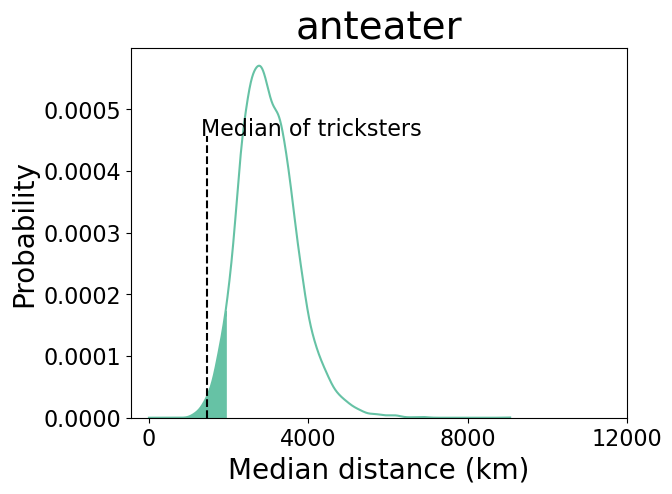

1


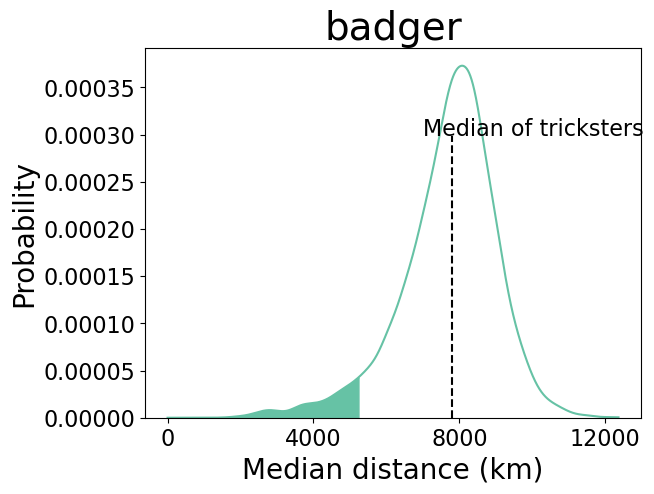

2


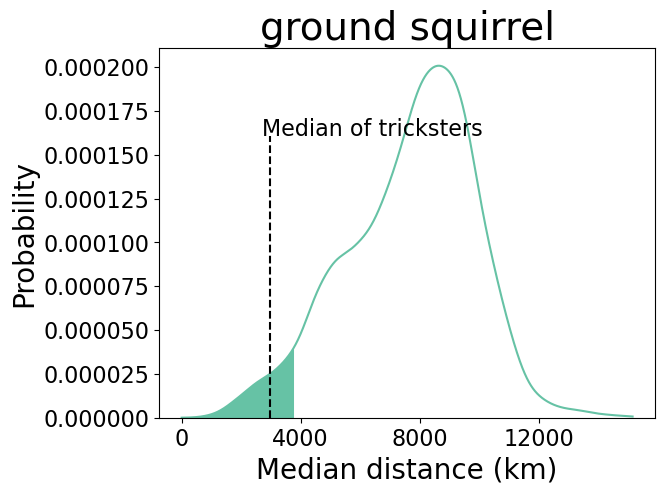

3


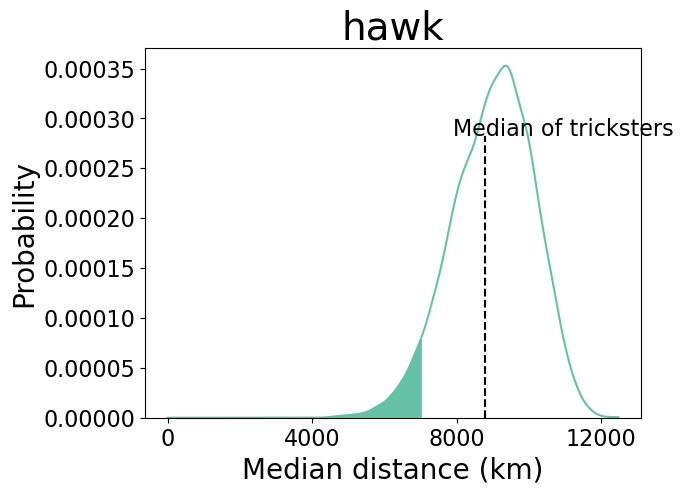

4


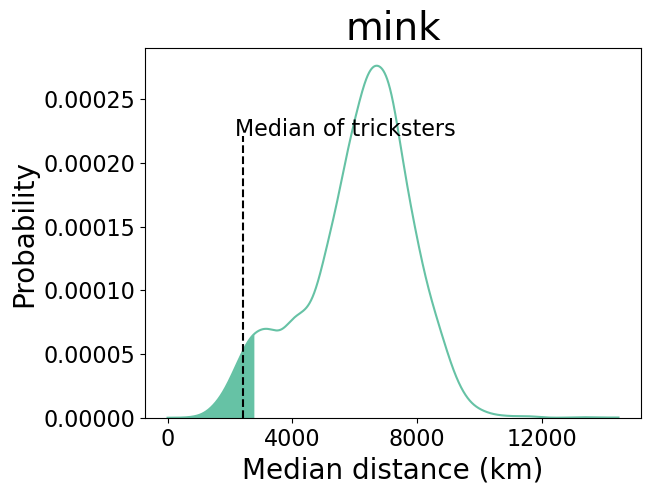

5


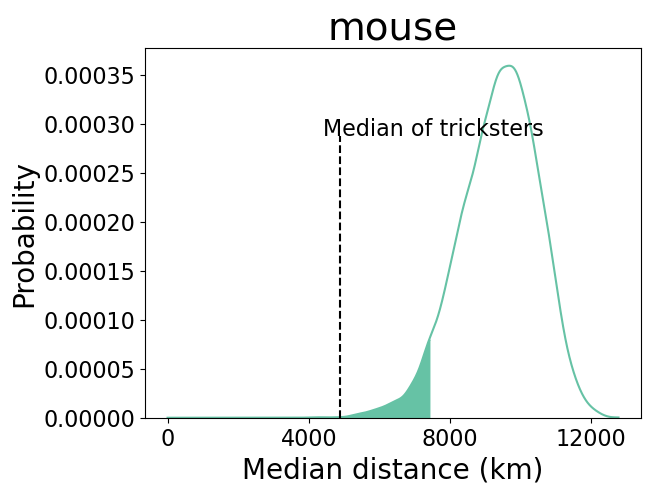

6


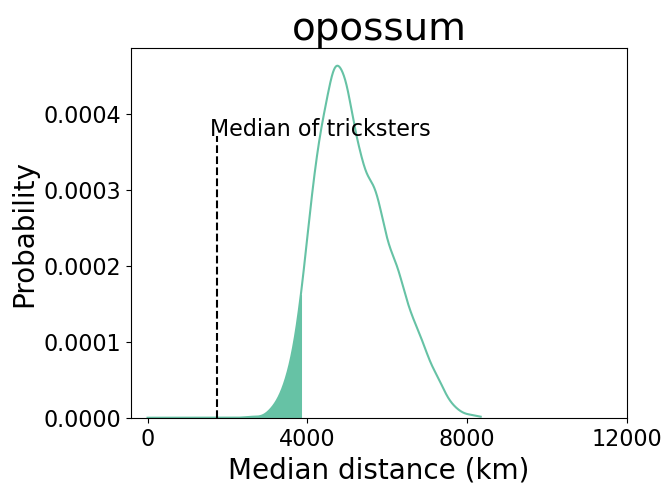

7


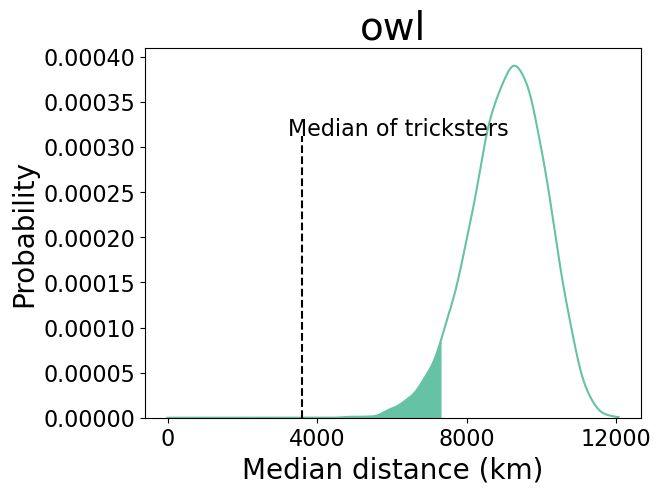

8


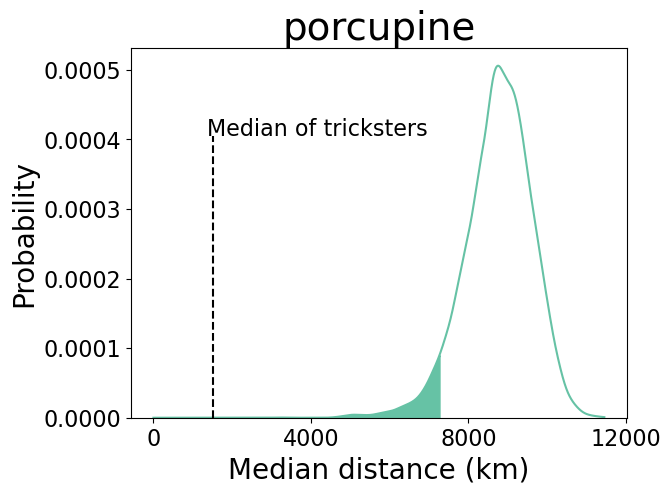

9


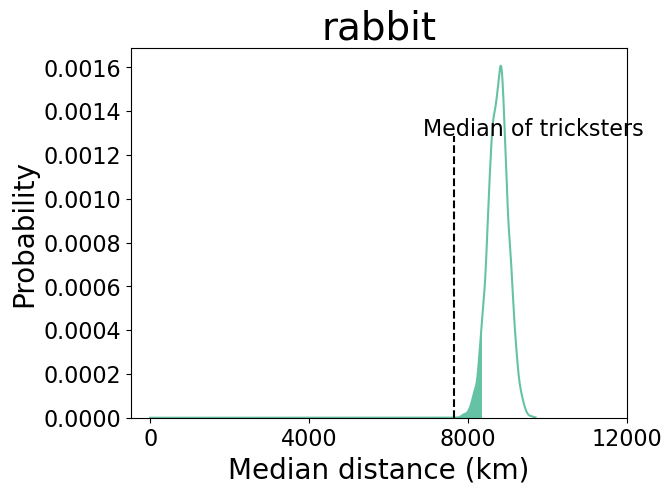

10


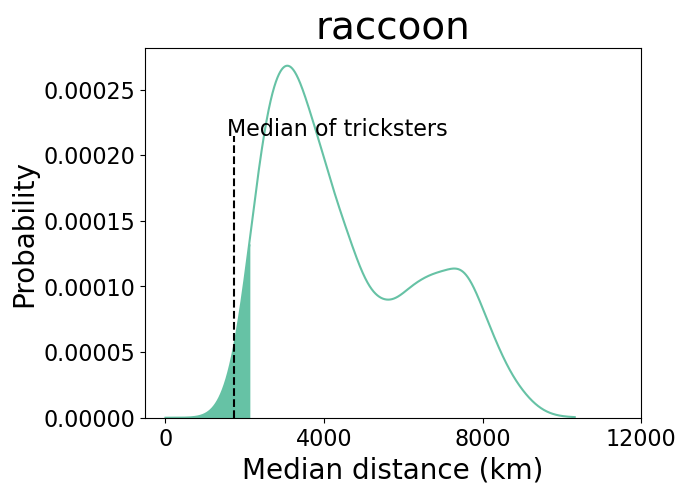

11


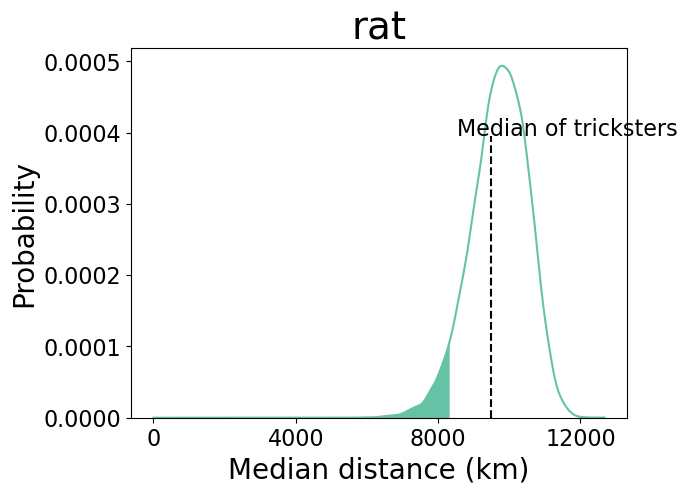

12


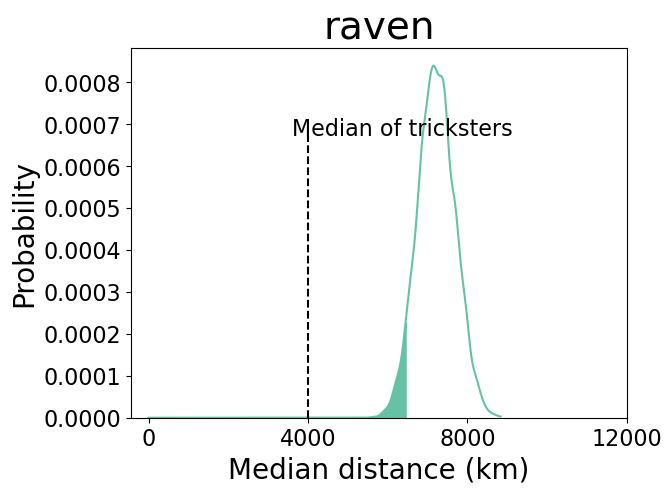

13


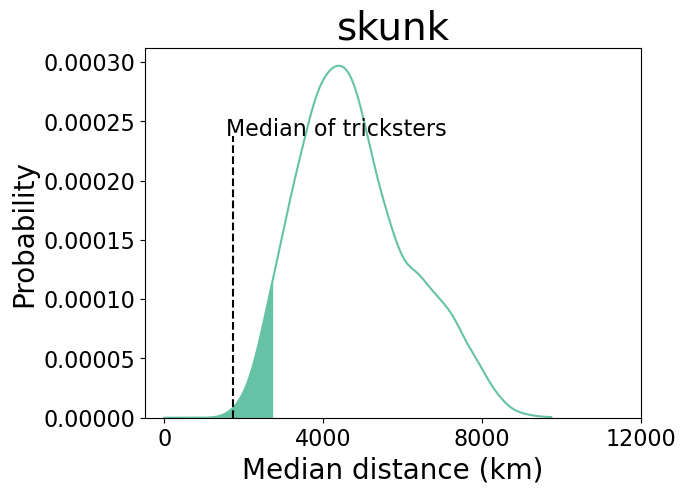

14


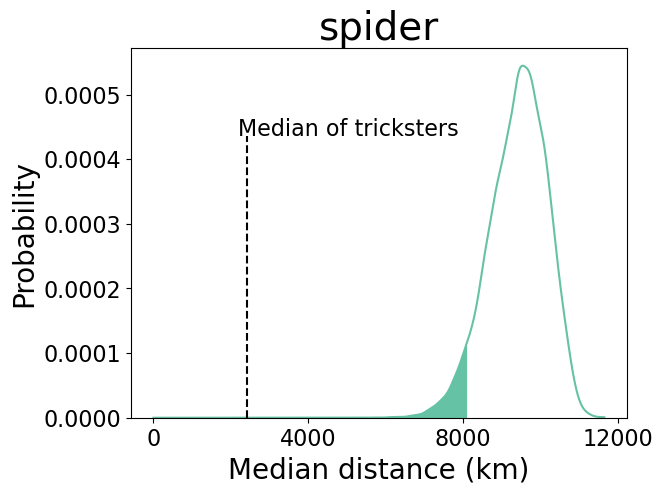

15


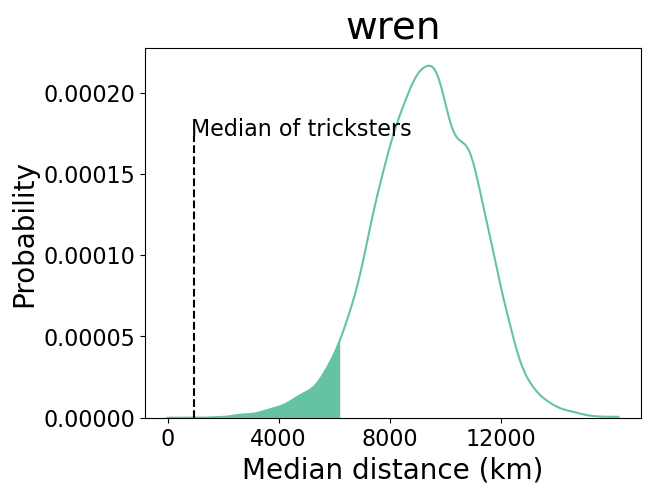

,Tricksters,P values
0,anteater,6.476656e-03
1,badger,4.710554e-01
2,ground squirrel,2.649974e-02
3,hawk,4.052021e-01
4,mink,3.007881e-02
5,mouse,4.084683e-04
6,opossum,1.006742e-12
7,owl,8.416279e-17
8,porcupine,6.573433e-40
9,rabbit,7.516883e-06


In [5]:
species=np.sort(np.unique(df["TrickSter"]))
P_vals=[]
for i in range(len(species)):
    target=species[i]
    print(i)
    P_vals.append(Distribution_Test(df, target, rep=10000))
    
df_result=pd.DataFrame({'Tricksters':species, 'P values':P_vals})     
df_result

In [6]:
df_result=pd.DataFrame({'Tricksters':species, 'P values':P_vals})  
a, b=multitest.fdrcorrection(df_result['P values'])
df_result['FDR']=a
df_result

,Tricksters,P values,FDR
0,anteater,6.476656e-03,True
1,badger,4.710554e-01,False
2,ground squirrel,2.649974e-02,True
3,hawk,4.052021e-01,False
4,mink,3.007881e-02,True
5,mouse,4.084683e-04,True
6,opossum,1.006742e-12,True
7,owl,8.416279e-17,True
8,porcupine,6.573433e-40,True
9,rabbit,7.516883e-06,True


## Combining all biome data

In [2]:
df_TS=pd.read_csv('TrickSter_data4.csv')
df=pd.DataFrame(
    {"hex_index":df_TS["hex_index"],
    "Annu_mean_temp":df_TS["Annu_mean_temp"],
    "Annu_prec":df_TS["Annu_mean_prec"],
    "Species":df_TS["TrickSter"]})
df["index"]="TS"
df

,hex_index,Annu_mean_temp,Annu_prec,Species,index
0,8204c7fffffffff,-11.830683,156.0,raven,TS
1,82104ffffffffff,-5.570597,566.0,raven,TS
2,820ceffffffffff,2.094879,822.0,raven,TS
3,8212effffffffff,2.942942,441.0,raven,TS
4,8226affffffffff,9.624741,413.0,raven,TS
...,...,...,...,...,...
450,8212f7fffffffff,0.651215,865.0,wren,TS
451,8228dffffffffff,9.138112,1037.0,wren,TS
452,8228c7fffffffff,NaN,NaN,wren,TS
453,8228f7fffffffff,11.432856,1112.0,wren,TS


In [12]:
# read all real animal distributiosn
df_meta=pd.read_csv('./GBIF/For_gbif_trickstar.xlsx - Sheet1.csv') # meta file
species=np.unique(df_meta['Category'])
for i in range(len(species)):
    target=species[i]
    print(target)
    if target != 'water bird' and target != 'monkey':
        taxa=df_meta[df_meta['Category']==target]['Taxa'].reset_index(drop=True)
        for j in range(len(taxa)):
            if j==0:
                data=pd.read_csv('./GBIF/'+target+'/'+taxa[j]+'_cleaned.csv')
                data["Species"]=target
            else:
                dd=pd.read_csv('./GBIF/'+target+'/'+taxa[j]+'_cleaned.csv')
                dd["Species"]=target
                data=pd.concat([data,dd])
        # drop overlapped index within the same animal category
        data=data.drop_duplicates("hex_index2")
        
    if i !=0:
        df_real=pd.concat([df_real,data])
    else:
        df_real=data
df_real=df_real.drop("hex_index", axis=1)
df_real.head()
    

anteater
badger
ground squirrel
hawk
mink
monkey
mouse
opossum
owl
porcupine
rabbit
raccoon
rat
raven
skunk
spider
water bird
wren


,decimalLongitude,decimalLatitude,hex_index2,Species
0,-55.980521,-20.088188,82a847fffffffff,anteater
1,-61.762567,-25.851655,82b34ffffffffff,anteater
3,-59.342764,3.764730,825f2ffffffffff,anteater
4,-54.724867,-16.680583,82a85ffffffffff,anteater
7,-71.864723,5.270644,826657fffffffff,anteater


In [23]:
Temp=[]
Prec=[]
for i in range(len(df_real)):
        #print(df['hex_index'][i])
        if i %1000000==0:
            print(i)
        x=h3.h3_to_geo_boundary(df_real["hex_index2"].iloc[i], True)
        x=np.mean(x, axis=0)
        d=get_climate(x[1], x[0])
        if np.isnan(d.tavg.ann)==True or np.isnan(sum(d.prec[1:12]))==True:
            # estimate from the data
            d_extract=df_real[df_real['hex_index2']==df_real["hex_index2"].iloc[i]]
            d_extract=d_extract[d_extract['decimalLatitude']<89.5] # unable to get data lat is too close to 90
            d_extract=d_extract[d_extract['decimalLongitude']<179.9] # unable to get data lng is too close to 180
            d=get_climate(d_extract.iloc[:, 1], d_extract.iloc[:, 0]) 
            Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature 
            Prec.append(np.nanmean(np.sum(d.prec.iloc[:,:12], axis=1))) # annual precipition
        else:
            Temp.append(d.tavg.ann)
            Prec.append(sum(d.prec[1:12]))
df_real['Annu_Mean_Temp']=Temp
df_real['Annu_Prec']=Prec
# drop unnecesary info
df_real=df_real.drop("decimalLongitude", axis=1)
df_real=df_real.drop("decimalLatitude", axis=1)
    
df_real.head()
df_real.to_csv("Real_Biome_distributions2.csv")
df_null=df_real.drop_duplicates("hex_index2") # real animal biome
df_null=df_null.drop("Species", axis=1)
df_real.to_csv("Null_Biome_distributions2.csv") # null biomeccf

0


/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_94507/3557409908.py:16: RuntimeWarning: Mean of empty slice
  Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_94507/3557409908.py:16: RuntimeWarning: Mean of empty slice
  Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_94507/3557409908.py:16: RuntimeWarning: Mean of empty slice
  Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_94507/3557409908.py:16: RuntimeWarning: Mean of empty slice
  Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipykernel_94507/3557409908.py:16: RuntimeWarning: Mean of empty slice
  Temp.append(np.nanmean(d.tavg.ann)) # annual average of temperature
/var/folders/g4/3cvylr8j6mq822n672x35vn40000gr/T/ipyker

KeyboardInterrupt: 